In [ ]:
#Datos
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Modelado
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn import metrics
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb

In [ ]:
propiedades = pd.read_csv('/content/dataframe_punto1.csv')

### Graficamos un pairplot para identificar los mejores features.

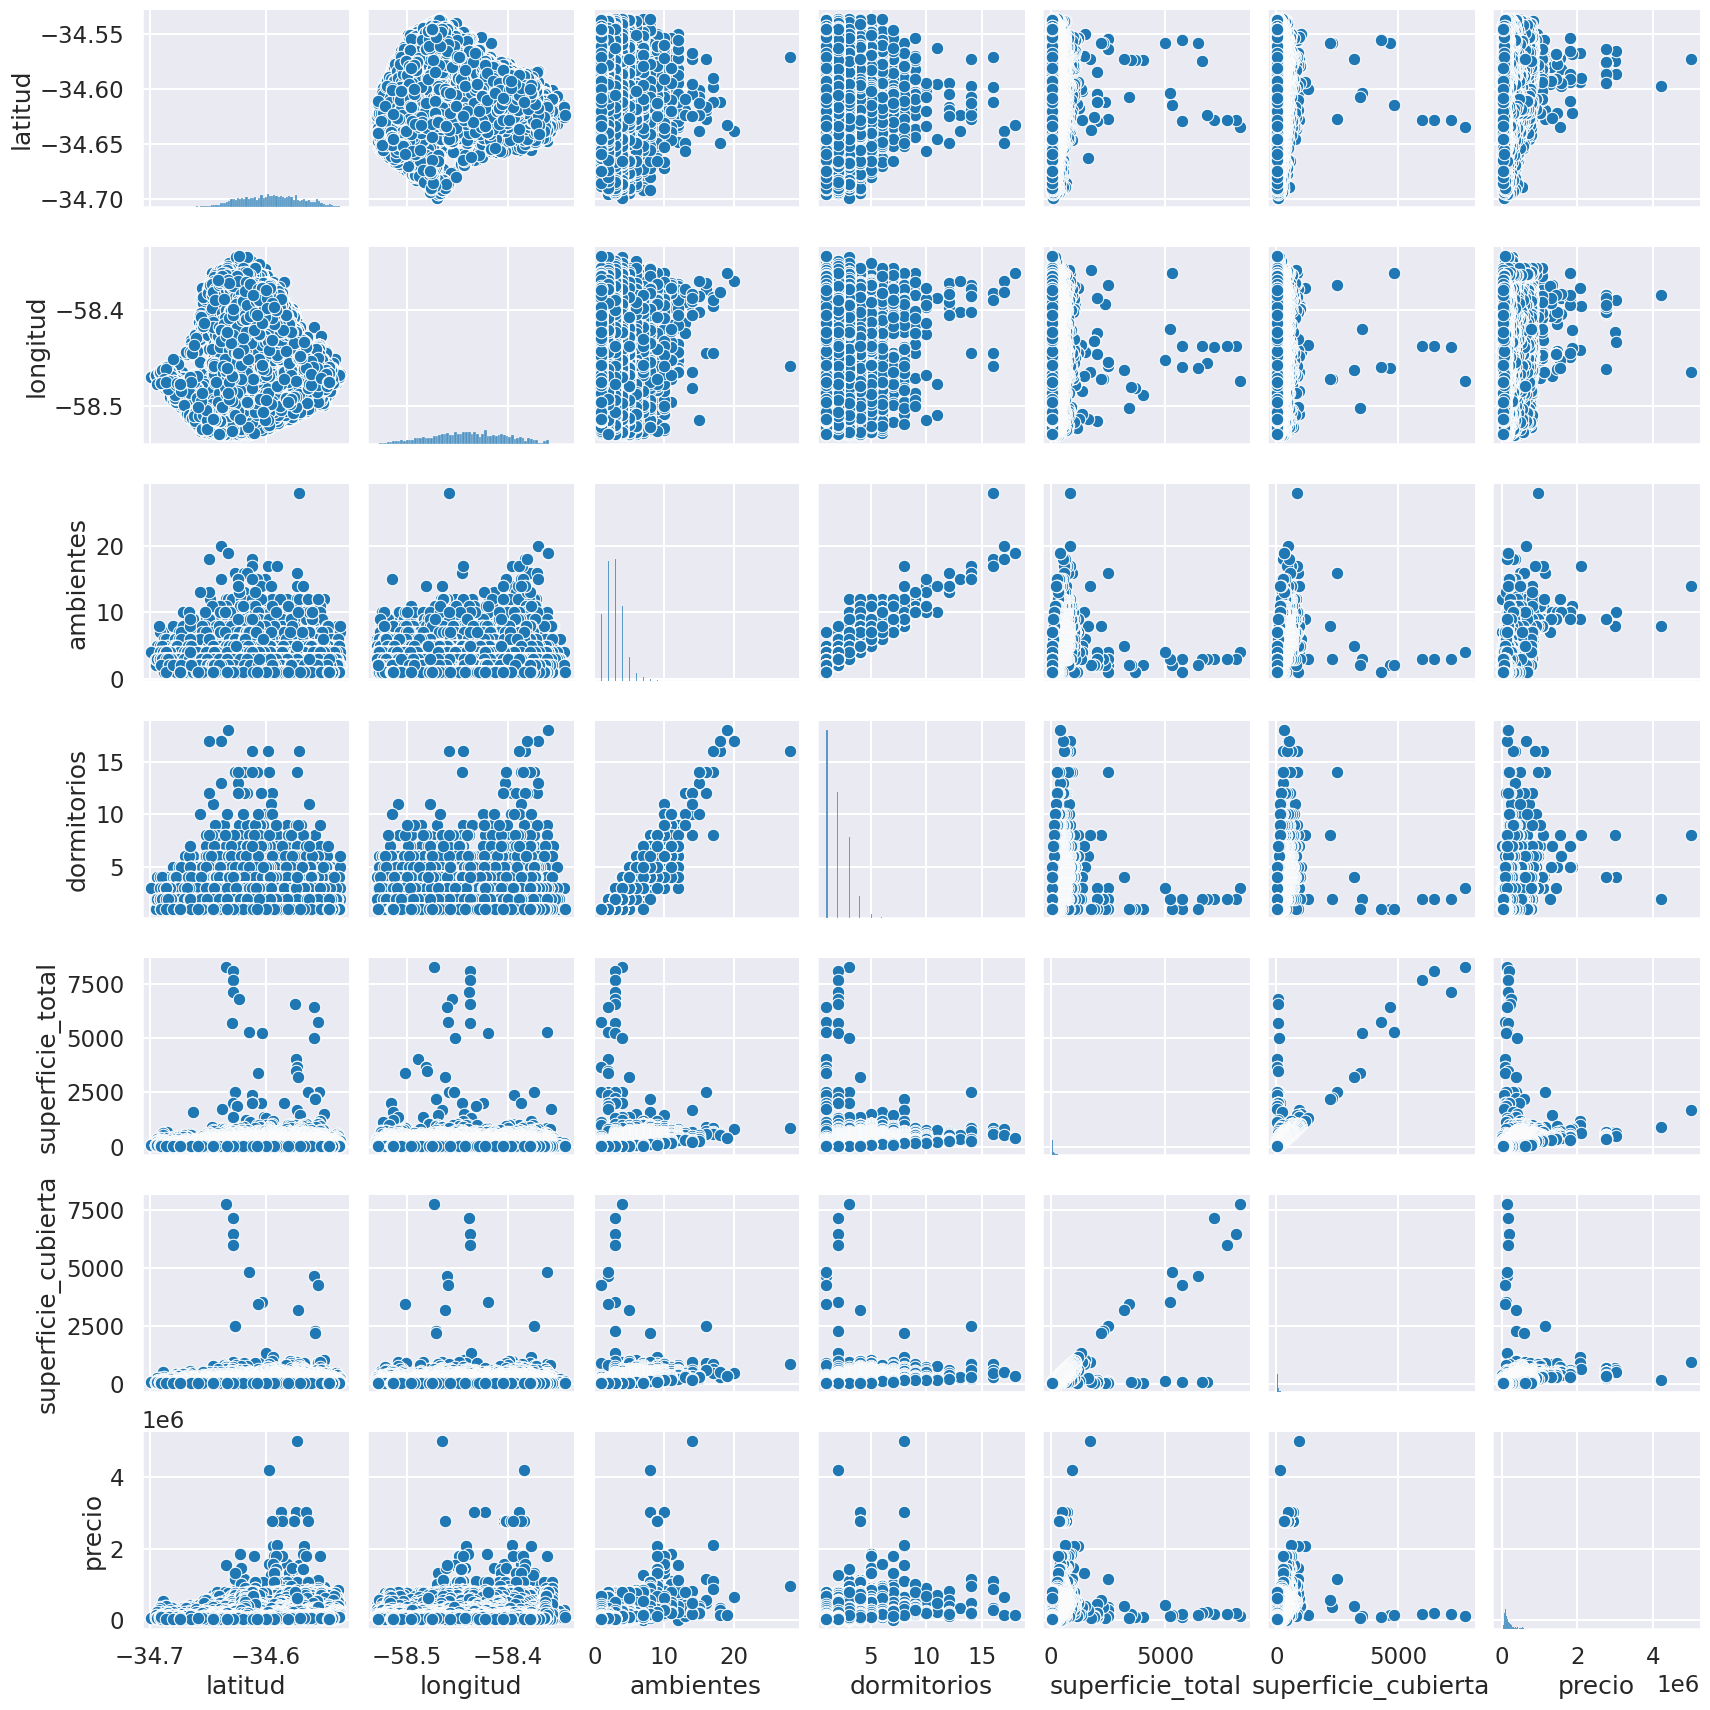

In [ ]:
sns.pairplot(propiedades)

### Del gráfico anterior podemos observar que **ambientes, dormitorios, superficie cubierta y superficie total** muestran una posible relación lineal con precio. Por lo tanto, vamos a analizar la correlación de los features con este último.

In [ ]:
propiedades_atributos = propiedades[propiedades.columns.difference(['id', 'barrio', 'fecha_inicio', 'fecha_fin', 'nombre', 'tipo'])]
propiedades_atributos.corr().style.background_gradient(cmap='coolwarm')

,ambientes,dormitorios,latitud,longitud,precio,superficie_cubierta,superficie_total
ambientes,1.000000,0.928469,-0.028850,0.012249,0.653450,0.560002,0.479715
dormitorios,0.928469,1.000000,-0.029589,0.009309,0.597936,0.538679,0.461726
latitud,-0.028850,-0.029589,1.000000,-0.140601,0.202522,0.022565,0.009519
longitud,0.012249,0.009309,-0.140601,1.000000,0.081791,0.032391,-0.008956
precio,0.653450,0.597936,0.202522,0.081791,1.000000,0.527717,0.446776
superficie_cubierta,0.560002,0.538679,0.022565,0.032391,0.527717,1.000000,0.835518
superficie_total,0.479715,0.461726,0.009519,-0.008956,0.446776,0.835518,1.000000


### Seleccionamos *ambientes, dormitorios, superficie_cubierta y superficie_total* como **variables regresoras** y a *precio* como la variable **a predecir**.

In [ ]:
X = propiedades[['ambientes', 'dormitorios', 'superficie_cubierta', 'superficie_total']]
y = propiedades.precio

### Separamos nuestro conjunto de train y test, en 80/20.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

In [ ]:
def propiedades_boxplot():
  sns.set_context('talk')
  sns.set_style("darkgrid")

  variables=[]
  valores=[]

  variables = ['ambientes']*len(list(X_train.ambientes)) + ['dormitorios']*len(list(X_train.dormitorios)) + ['superficie_cubierta']*len(list(X_train.superficie_cubierta)) + ['superficie_total']*len(list(X_train.superficie_total))

  valores = list(X_train.ambientes) + list(X_train.dormitorios) + list(X_train.superficie_cubierta) + list(X_train.superficie_total)

  plt.figure(figsize=(20,20))
  grafico=sns.boxplot(x=variables,y=valores)
  grafico.set(xlabel='Variable')

### Graficamos un boxplot para ver la cantidad de outliers de cada feature

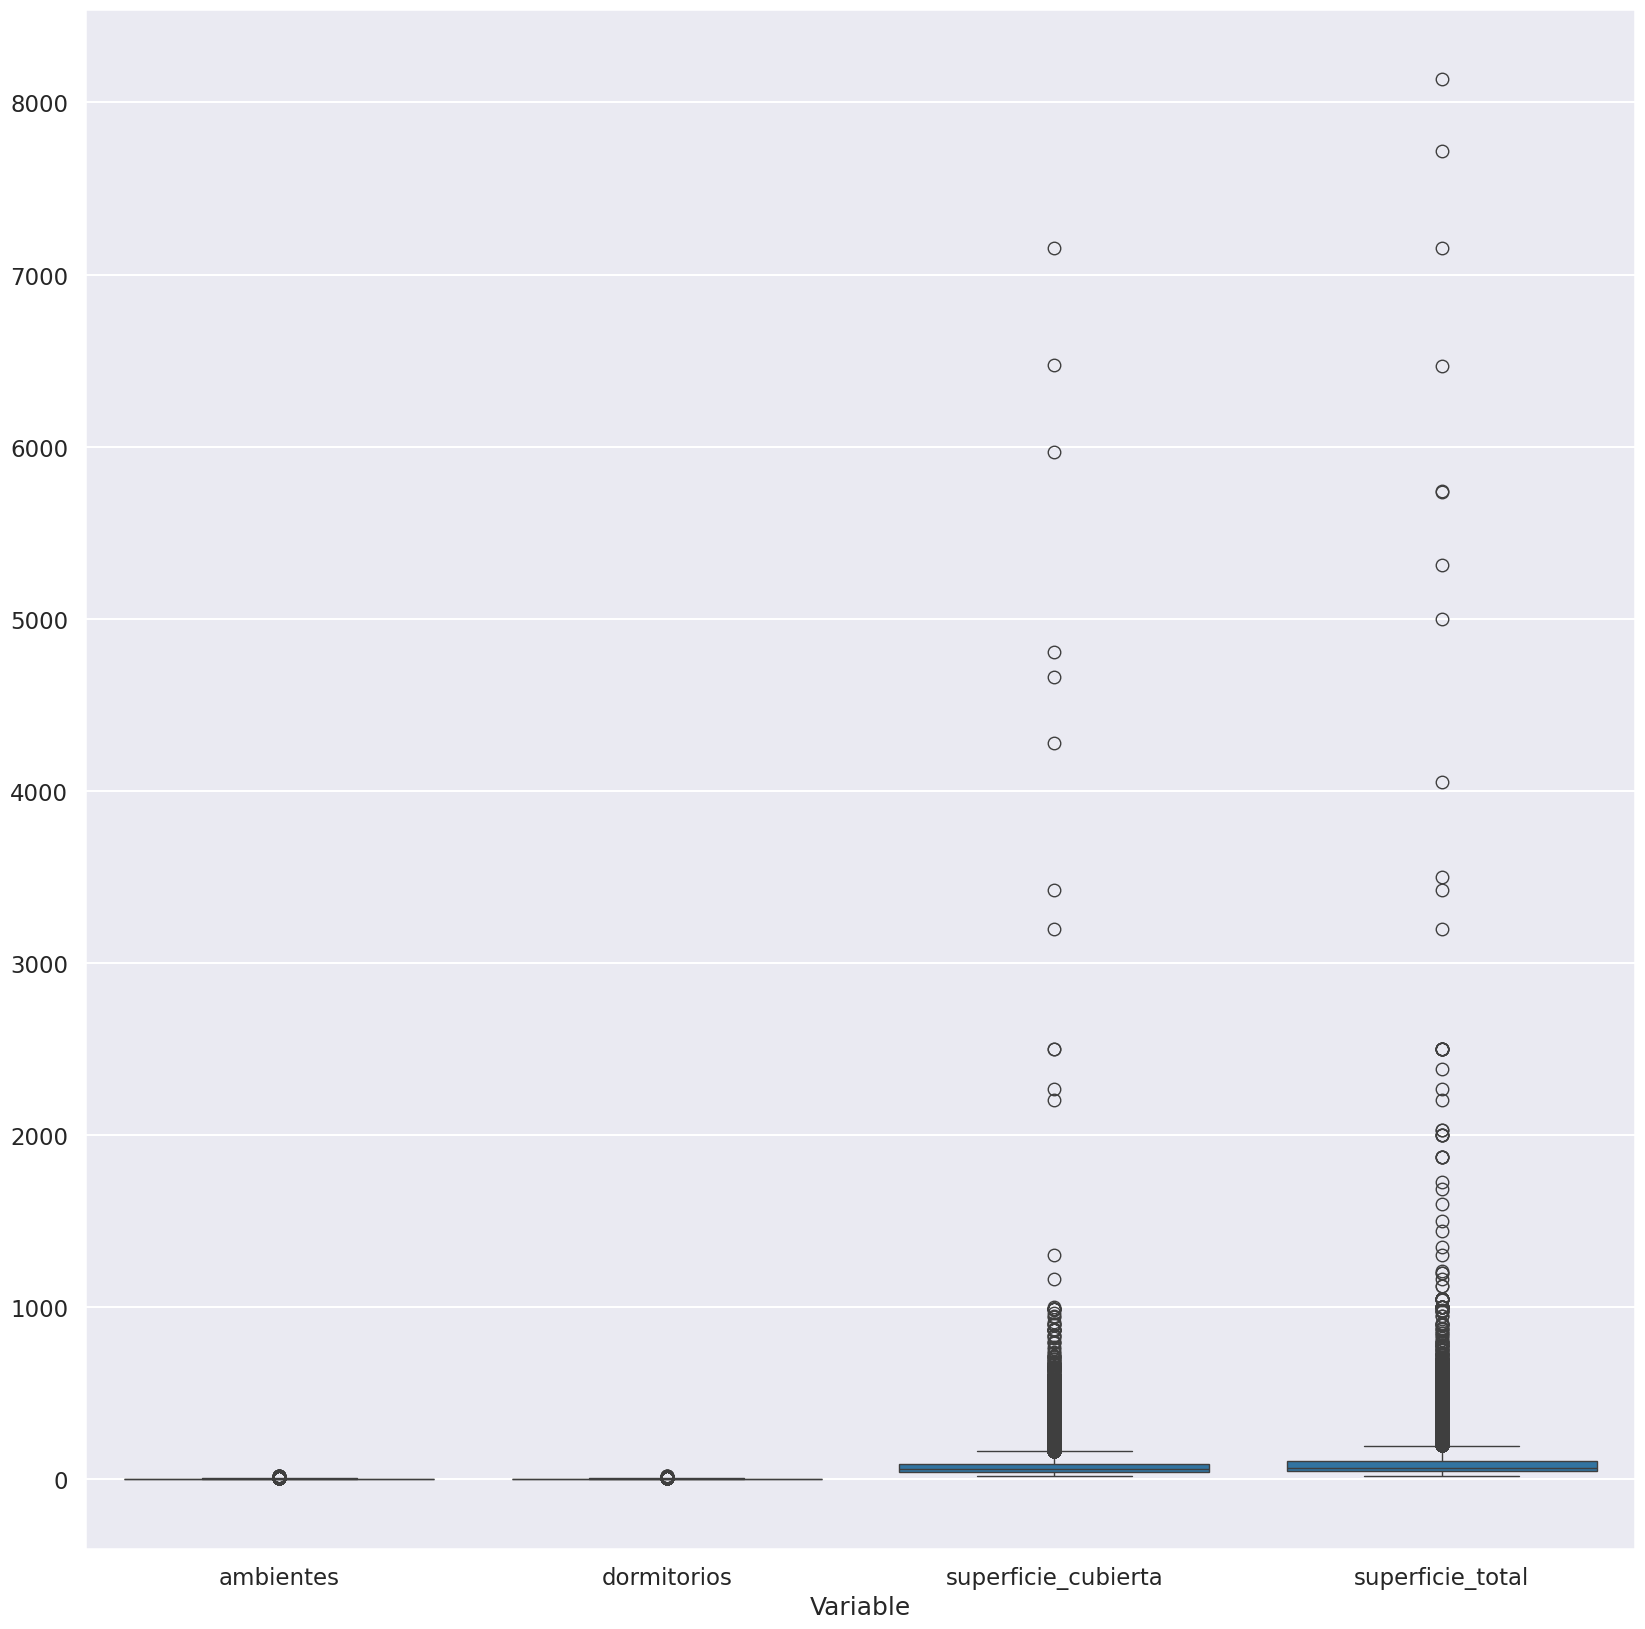

In [ ]:
propiedades_boxplot()

### Sabemos que las regresiones son suceptibles a los outliers. Por este motivo procederemos a elminarlos con la regla del 1.5*IQR, dejando solo las observaciones que esten entre 1.5 veces el rango entre cuartiles.

In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
ambientes,59208.0,2.843889,1.405505,1.0,2.0,3.0,4.0,20.0
dormitorios,59208.0,1.915197,1.056746,1.0,1.0,2.0,3.0,18.0
superficie_cubierta,59208.0,79.519913,92.657322,20.0,40.0,58.0,89.0,7153.0
superficie_total,59208.0,94.713046,122.114551,20.0,46.0,67.0,106.0,8136.0


In [ ]:
#Calculo los cuantiles de las variables ambientes, dormitorios, superficie_cubierta, superficie_total
ambientes_q3, ambientes_q1 = np.percentile(X_train.ambientes, [75 ,25])
dormitorios_q3, dormitorios_q1 = np.percentile(X_train.dormitorios, [75 ,25])
superficie_cubierta_q3, superficie_cubierta_q1 = np.percentile(X_train.superficie_cubierta, [75 ,25])
superficie_total_q3, superficie_total_q1 = np.percentile(X_train.superficie_total, [75 ,25])

#Calculo e rango intercuartil de las variables de ambientes, dormitorios, superficie_cubierta, superficie_total
iqr_ambientes = ambientes_q3 - ambientes_q1
iqr_dormitorios = dormitorios_q3 - dormitorios_q1
iqr_superficie_cubierta = superficie_cubierta_q3 - superficie_cubierta_q1
iqr_superficie_total = superficie_total_q3 - superficie_total_q1

# Elimino outliers de la variable 'ambientes'
X_train = X_train.query(' ambientes >= (@ambientes_q1 - @iqr_ambientes*1.5) & ambientes <= (@ambientes_q3 + @iqr_ambientes*1.5) ')
y_train = y_train[X_train.index]

# Elimino outliers de la variable 'dormitorios'
X_train = X_train.query(' dormitorios >= (@dormitorios_q1 - @iqr_dormitorios*1.5) & dormitorios <= (@dormitorios_q3 + @iqr_dormitorios*1.5) ')
y_train = y_train[X_train.index]

# Elimino outliers de la variable 'superficie_cubierta'
X_train = X_train.query(' superficie_cubierta >= (@superficie_cubierta_q1 - @iqr_superficie_cubierta*1.5) & superficie_cubierta <= (@superficie_cubierta_q3 + @iqr_superficie_cubierta*1.5) ')
y_train = y_train[X_train.index]

# Elimino outliers de la variable 'superficie_total'
X_train = X_train.query(' superficie_total >= (@superficie_total_q1 - @iqr_superficie_total*1.5) & superficie_total <= (@superficie_total_q3 + @iqr_superficie_total*1.5) ')
y_train = y_train[X_train.index]

### Ahora que tenemos el conjunto filtrado graficamos nuevamente para ver los resultados.

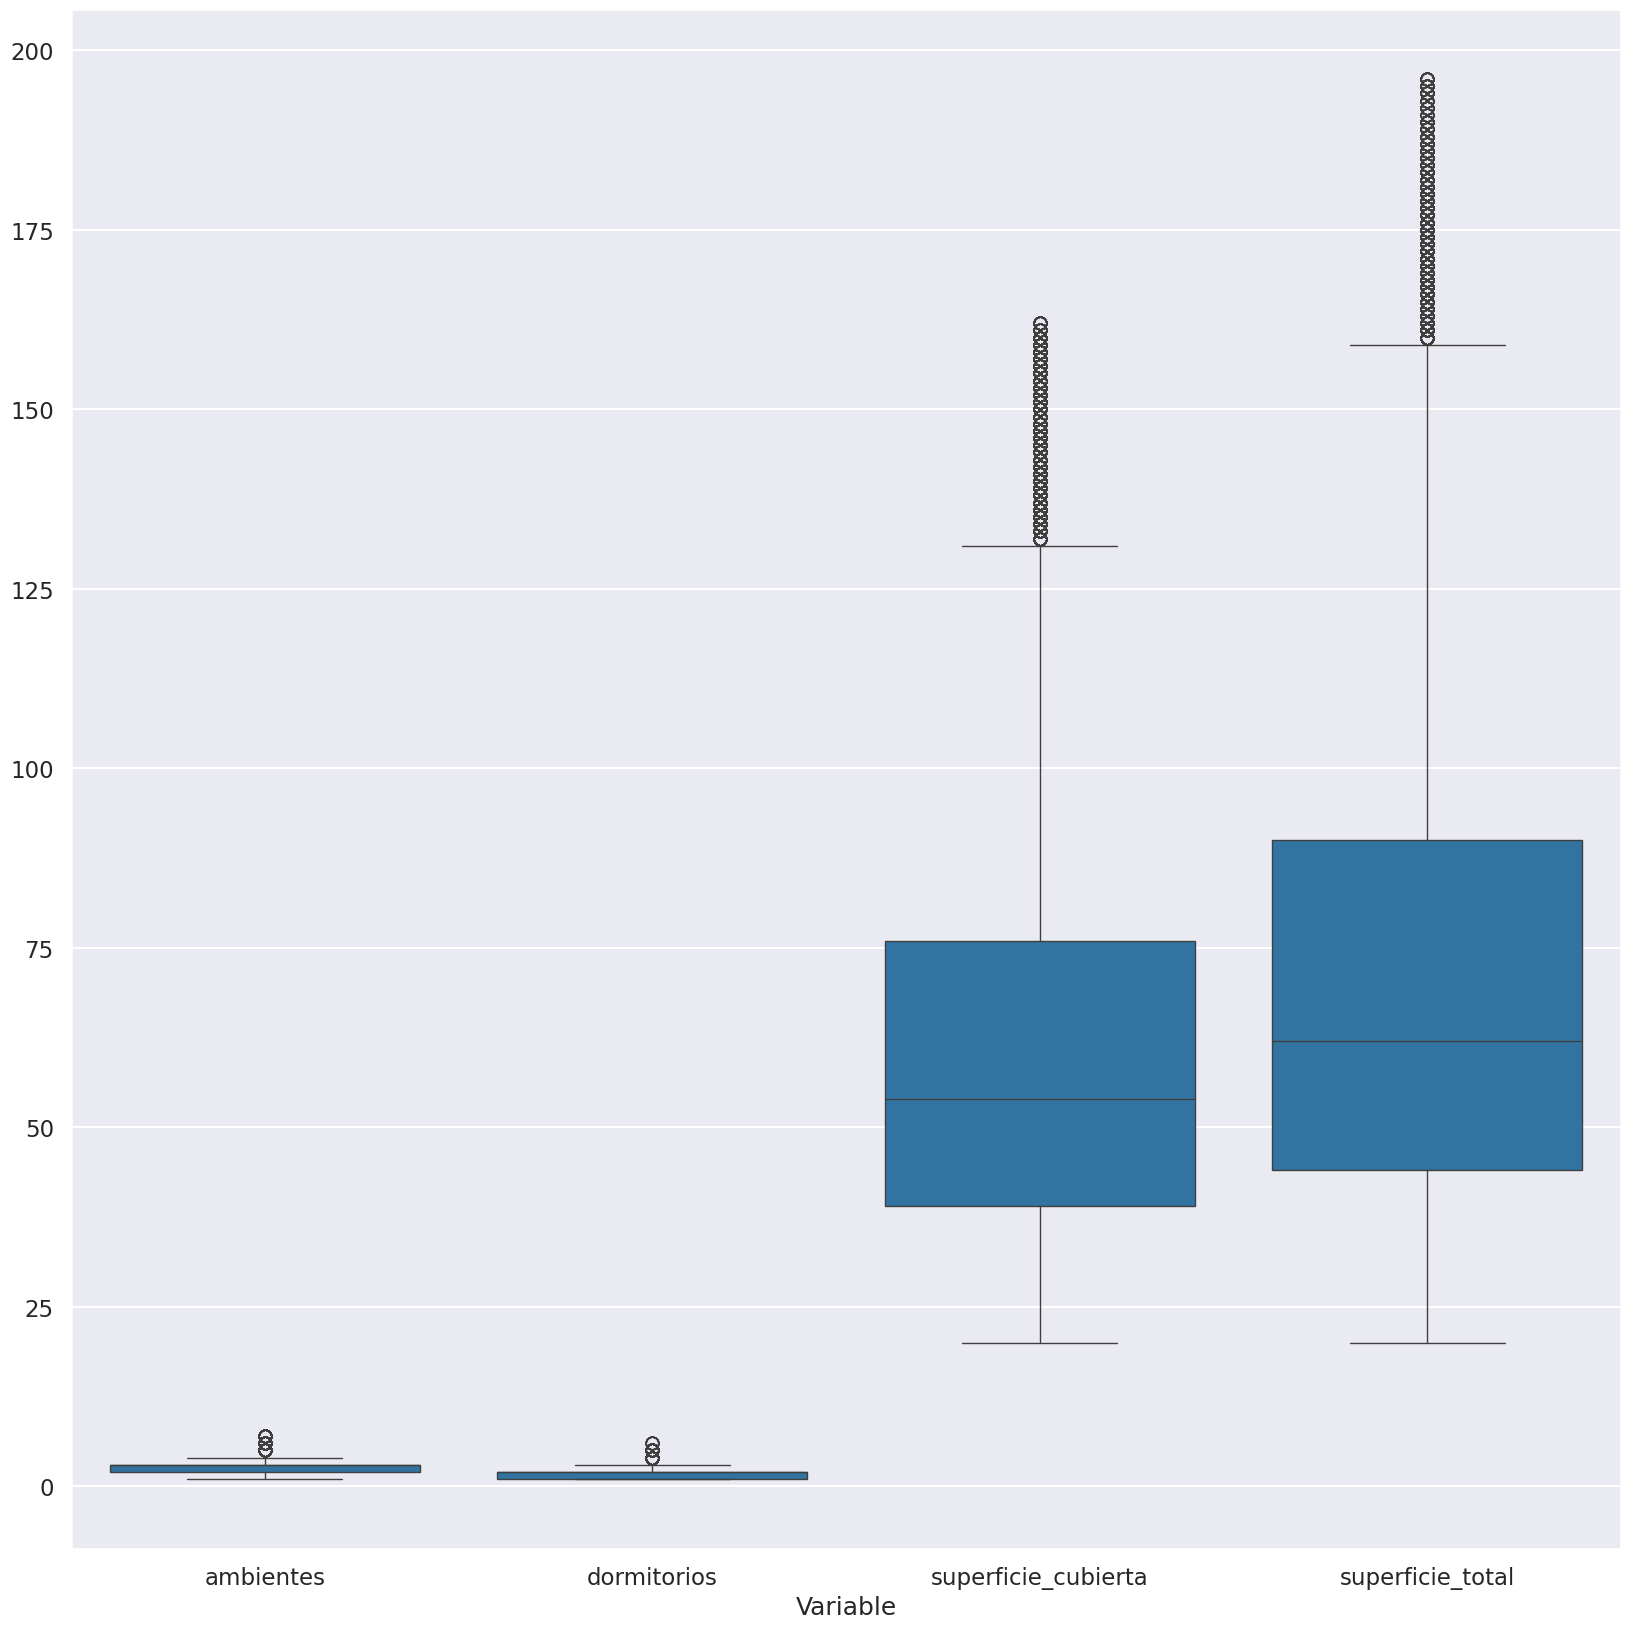

In [ ]:
propiedades_boxplot()

In [ ]:
X_train.corr().style.background_gradient(cmap='coolwarm')

,ambientes,dormitorios,superficie_cubierta,superficie_total
ambientes,1.000000,0.920435,0.803121,0.766238
dormitorios,0.920435,1.000000,0.792334,0.751764
superficie_cubierta,0.803121,0.792334,1.000000,0.925087
superficie_total,0.766238,0.751764,0.925087,1.000000


In [ ]:
#sns.scatterplot(x=X_train.ambientes,y=y_train)
#sns.scatterplot(x=X_train.dormitorios,y=y_train)
#sns.scatterplot(x=X_train.superficie_cubierta,y=y_train)
#sns.scatterplot(x=X_train.superficie_total,y=y_train)

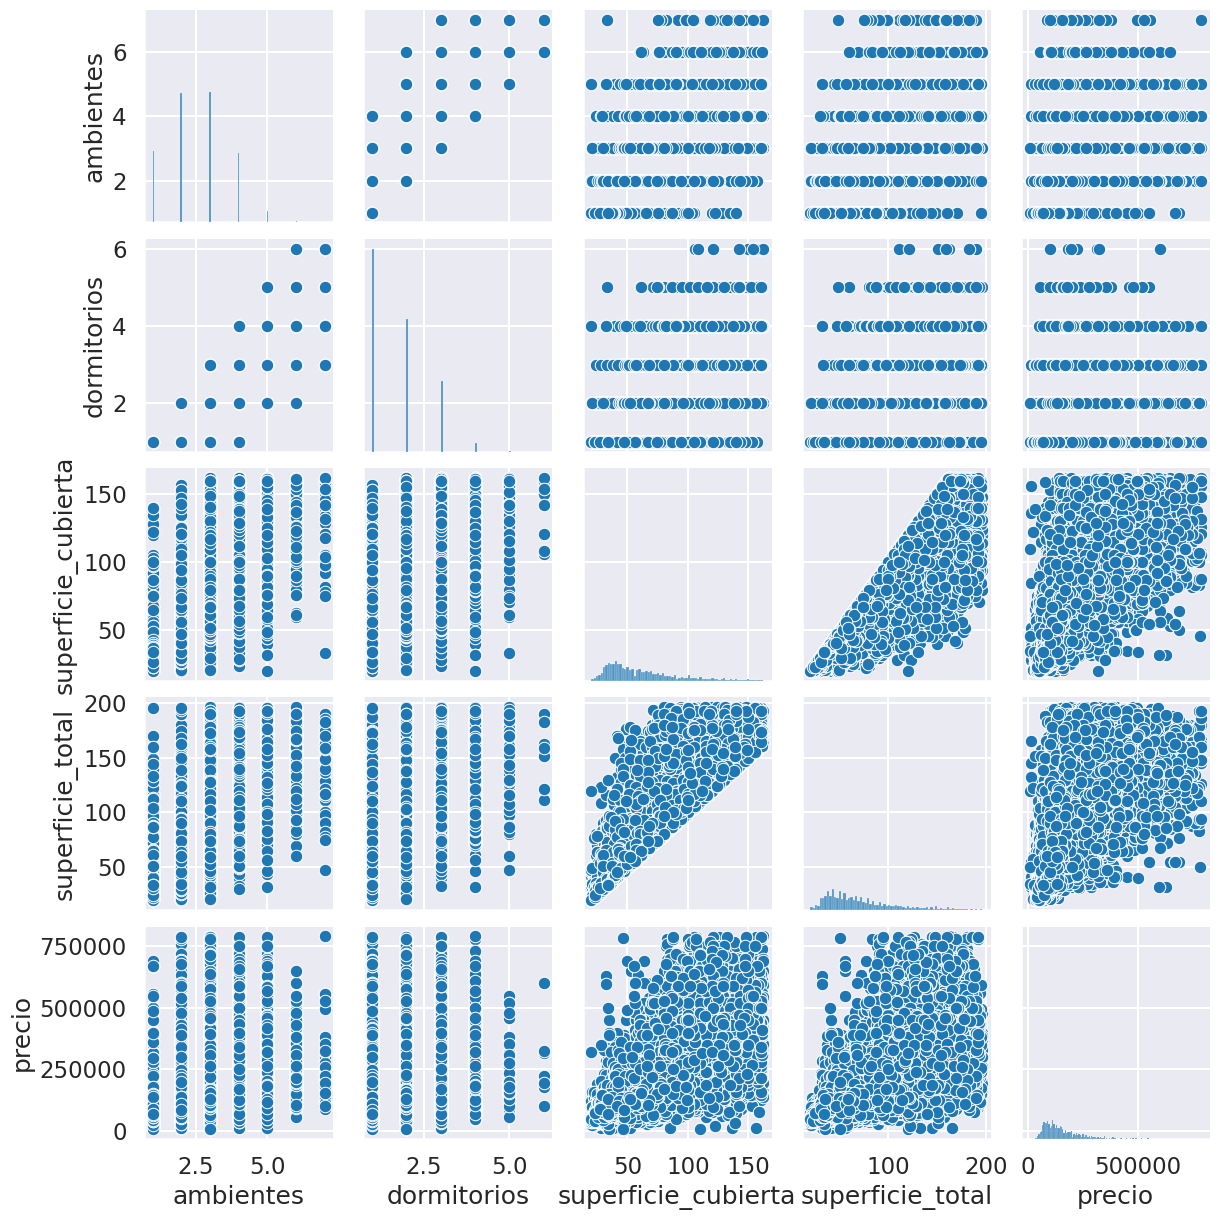

In [ ]:
#Grafico de a pares incluyendo variable a predecir
xy_train_sin_outliers = pd.concat([X_train, y_train], axis=1)
sns.pairplot(xy_train_sin_outliers)

### Creamos el modelo KNN, ajustamos y relaizamos una predicción.

In [ ]:
knn_regressor = KNeighborsRegressor().fit(X_train, y_train)
y_pred = knn_regressor.predict(X_test)

### Visualizamos la performance.

In [ ]:
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred,
                            'Error': y_test - y_pred})
performance.head()

,Valor Real,Prediccion,Error
53361,155000.0,123200.0,31800.0
54223,105000.0,91800.0,13200.0
47367,151200.0,169400.0,-18200.0
6553,213762.0,436064.4,-222302.4
65064,99000.0,75200.0,23800.0


### Visualizamos el error cuadrático medio, su raíz...

In [ ]:
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

El error (mse) de test es: 13544335932.614141
El error (rmse) de test es: 116380.1354725717


### ... y R2 score.

In [ ]:
score_knn = knn_regressor.score(X_test, y_test)
score_knn

0.48250316588276854

### Veamos si mejoramos R2 score utilizando cross validation con un 10 folds.

In [ ]:
kfoldcv = KFold(10)
knncv = KNeighborsRegressor()
scorer_fn = make_scorer(r2_score)
resultados = cross_validate(knncv,X_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)
metricsCV=resultados['test_score']
mejor_performance=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]

<Axes: >

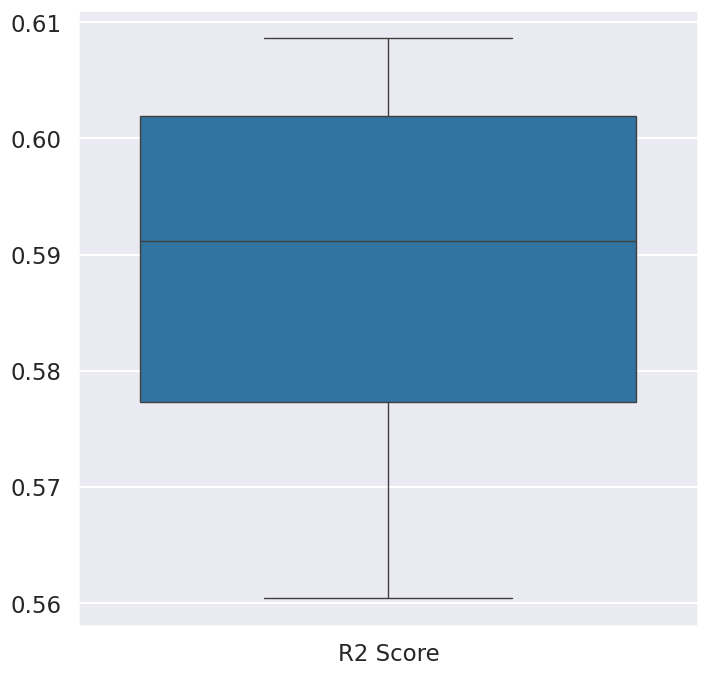

In [ ]:
metric_labelsCV = ['R2 Score']*len(metricsCV)
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(x = metric_labelsCV,y=metricsCV)

In [ ]:
#from sklearn.metrics import confusion_matrix, classification_report
#
##Predicción sobre el set de evaluacion
#y_pred= mejor_performance.predict(X_test).round()
#
##Arbol Reporte y Matriz de Confusion
#print(classification_report(y_test,y_pred))

#cm = confusion_matrix(y_test,y_pred)
#sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
#plt.xlabel('Predicted')
#plt.ylabel('True')

### xgboost con regresión

### Vamos a utlizar xgboost con regresión y cross validation para obtener un R2 score.

In [ ]:
xgbr = xgb.XGBRegressor(seed=10)
resultados = cross_validate(xgbr,X_train, y_train, cv=kfoldcv, scoring=scorer_fn,return_estimator=True)
metricsCV=resultados['test_score']
mejor_performance=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]

### Graficamos el R2 score con boxplot para comparar el obtenido con KNN

<Axes: >

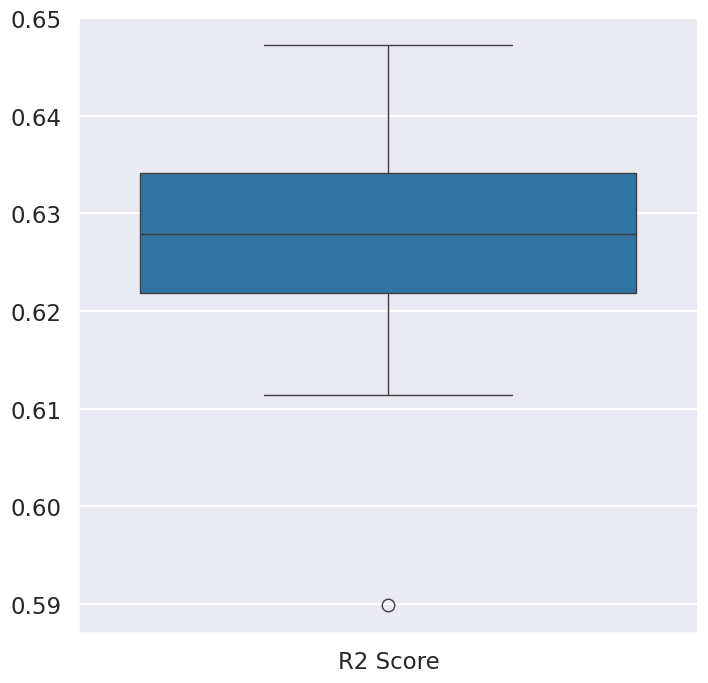

In [ ]:
metric_labelsCV = ['R2 Score']*len(metricsCV)
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(x = metric_labelsCV,y=metricsCV)